In [2]:
from pathlib import Path

In [3]:
import pandas as pd
import numpy as np
import string
import re

In [4]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [5]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

In [59]:
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.nmf import Nmf
from gensim.models import LsiModel
from gensim.models.ldamodel import LdaModel

#### Directories

In [7]:
proj_dir = Path().absolute().parents[0]
data_dir = Path(proj_dir, 'data')

#### Read in data

In [8]:
reviews = pd.read_csv(Path(data_dir, 'raw', 'comcast_consumeraffairs_complaints.csv'))

In [9]:
reviews.head()

,author,posted_on,rating,text
0,"Alantae of Chesterfeild, MI","Nov. 22, 2016",1,I used to love Comcast. Until all these consta...
1,"Vera of Philadelphia, PA","Nov. 19, 2016",1,I'm so over Comcast! The worst internet provid...
2,"Sarah of Rancho Cordova, CA","Nov. 17, 2016",1,If I could give them a negative star or no sta...
3,"Dennis of Manchester, NH","Nov. 16, 2016",1,I've had the worst experiences so far since in...
4,"Ryan of Bellevue, WA","Nov. 14, 2016",1,Check your contract when you sign up for Comca...


#### Plot ratings

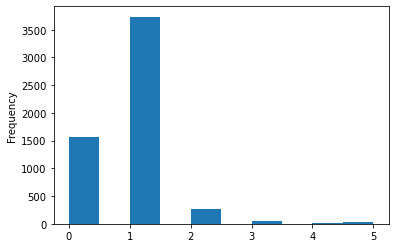

In [10]:
reviews['rating'].plot.hist()

#### Tokenize

In [11]:
spacy_nlp = spacy.load('en_core_web_sm')
stop_words = STOP_WORDS
punctuations = string.punctuation

In [12]:
# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = spacy_nlp(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    # Remove non words
    mytokens = [ word for word in mytokens if not re.search('[^A-Za-z]+', word) ]
    
    # return preprocessed list of tokens
    return mytokens

In [13]:
reviews['text'] = reviews['text'].astype('str')

In [14]:
reviews['tokenized'] = reviews['text'].apply(spacy_tokenizer)

In [18]:
# Create the Corpus
mydict = corpora.Dictionary(reviews['tokenized'])
bow_corpus = [mydict.doc2bow(doc) for doc in reviews['tokenized']]

#### Create TFIDF

In [19]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

#### input number of topics

In [66]:
n_topics = 4

#### Case

In [78]:
case = 1

#### SVD

In [67]:
svd = LsiModel(corpus_tfidf, id2word=mydict, num_topics = n_topics)
svd_transformed = svd[corpus_tfidf]  # vectorize input copus in BoW format

In [68]:
svd_transformed[case]

[(0, 0.11299256154819629),
 (1, 0.02257291370772579),
 (2, -0.08422240875753051),
 (3, 0.0018016972808296851)]

In [69]:
svd.show_topics(num_words = 5)

[(0,
  '0.160*"bill" + 0.138*"tell" + 0.126*"charge" + 0.126*"month" + 0.125*"box"'),
 (1,
  '-0.313*"bill" + 0.269*"appointment" + 0.239*"tech" + 0.207*"technician" + -0.173*"payment"'),
 (2,
  '-0.288*"channel" + -0.249*"speed" + 0.242*"account" + 0.208*"payment" + -0.172*"tv"'),
 (3,
  '-1.000*"nan" + -0.004*"june" + 0.003*"offer" + 0.003*"lie" + 0.003*"bank"')]

#### NMF

In [70]:
nmf = Nmf(corpus_tfidf, id2word=mydict, num_topics = n_topics)
nmf_transformed = nmf[corpus_tfidf]  # vectorize input copus in BoW format

In [71]:
nmf_transformed[case]

[(2, 0.033212312892669085), (3, 0.95733650613999)]

In [72]:
nmf.show_topics(num_words = 5)

[(0,
  '0.012*"account" + 0.010*"number" + 0.009*"payment" + 0.007*"bill" + 0.007*"email"'),
 (1,
  '0.015*"appointment" + 0.014*"tech" + 0.009*"come" + 0.009*"schedule" + 0.008*"wait"'),
 (2,
  '0.012*"bill" + 0.010*"contract" + 0.010*"charge" + 0.010*"fee" + 0.008*"month"'),
 (3,
  '0.011*"modem" + 0.010*"box" + 0.007*"internet" + 0.007*"tv" + 0.006*"xfinity"')]

#### LDA

In [73]:
lda = LdaModel(bow_corpus, id2word=mydict, num_topics = n_topics)
lda_transformed = lda[bow_corpus]  # vectorize input copus in BoW format

In [74]:
lda_transformed[case]

[(2, 0.97137696)]

In [75]:
lda.show_topics(num_words = 5)

[(0,
  '0.040*"comcast" + 0.021*"service" + 0.016*"time" + 0.014*"tell" + 0.010*"account"'),
 (1,
  '0.035*"service" + 0.032*"comcast" + 0.020*"tell" + 0.020*"cable" + 0.013*"time"'),
 (2,
  '0.047*"service" + 0.026*"comcast" + 0.015*"customer" + 0.013*"phone" + 0.013*"pay"'),
 (3,
  '0.031*"comcast" + 0.022*"bill" + 0.022*"tell" + 0.022*"service" + 0.018*"month"')]

In [76]:
reviews['text'][0]

"I used to love Comcast. Until all these constant updates. My internet and cable crash a lot at night, and sometimes during the day, some channels don't even work and on demand sometimes don't play either. I wish they will do something about it. Because just a few mins ago, the internet have crashed for about 20 mins for no reason. I'm tired of it and thinking about switching to Wow or something. Please do not get Xfinity."